## Final Project Submission

Please fill out:
* Student names: **Dominic Mugo, Jacquiline Tulinye, Dennis Mutuku, Onesphoro Kibunja**
* Student pace: **Part time**
* Scheduled project review date/time: **11/09/23 : 06:00am**
* Instructor name: **Stella Waithera, Mwikali Maryann, Asha Deen**
* Blog post URL:


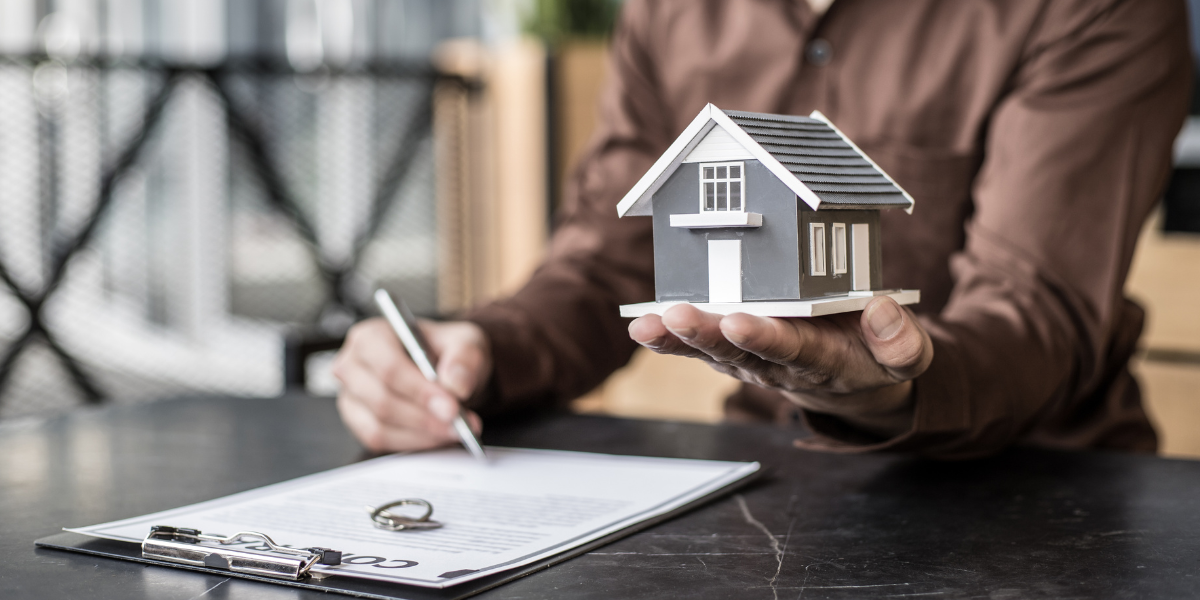









## OVERVIEW

Real estate simply put, refers to the land, plus any permanent man-made additions, such as houses and other buildings. Any additions or changes to the land that affects the property's value are called an improvement.Once land is improved, the total capital and labor used to build the improvement represent a sizable fixed investment. Though a building can be razed, improvements like drainage, electricity, water and sewer systems tend to be permanent.<a href="https://www.investopedia.com/terms/r/realestate.asp">Investopedia</a>

Real estate market is a trillion dollar industry globally that is valued at USD 3.69 trillion as of 2021 and is expected to have an annual growth rate of 5.2% till 2030. This is a very healthy growth rate that ensures profitable returns to potential investors in the field.

America has a population of approximately 340 million people. All these people require shelter as it is a basic necessity, which means these are all home-owners or potential home owners.

Real estate in america hit rock bottom in 2012 mean the cost of housing was extremely high and few people could afford it. This deterred many investors. However in a post covid world, many mainstream analysts are saying that now is a ripe time to come back for potential investors. Ivy Zelman an analyst who predicted the crash in 2005 now claims that things are looking up now. <a href="https://www.economist.com/finance-and-economics/2022/04/09/the-american-property-market-is-once-again-looking-bubbly?utm_medium=cpc.adword.pd&utm_source=google&ppccampaignID=17210591673&ppcadID&utm_campaign=a.22brand_pmax&utm_content=conversion.direct-response.anonymous">The Economist</a>

Furthermore we can see the price of houses has been on a steady increase over the years. <a href="https://www.redfin.com/us-housing-market">Redfin</a>

In addition, despite high mortgage rates and home prices, this forbes article claims that the market remains as competitive as ever due to demand levels surpassing the ongoing crunch. <a href="https://www.forbes.com/advisor/mortgages/real-estate/housing-market-predictions/">Forbes</a>

Real estate is a physical asset with the potential to appreciate in value over time. In fact, historical data shows that real estate appreciates at a higher rate than the rate of inflation. This means that over time, the value of your property will increase, which can lead to significant profits.

## Business Problem

As we can see the industry is a very lucrative but also has the ability to cause great losses when house pricing gets out of control. This means that potential investors have to make smart and informed decisions so as to safe guard their money, they want to get maximum value, no matter how much is spent. After all who likes to be known to make poor investment decisions and what better way to ensure this than with data driven decision making.

With this in mind we want to help our stakeholders KC Real Estate Agency to make the right decisions with their money as they venture to bring more, better and nicer homes to the 340 million americans.

How do we go about ensuring that this real estate agency gets the most out of its money? We've setup the following objectives to help guide:

**1. To determine which variables affect house pricing, more specifically those that increase the value of a house.**

**2. Factors that affect grade of a house. We want to invest in only high grade houses despite the price.**

**3.** 


## Data Understanding

We got our data from King County House Sales dataset to aid us in the decision making. This dataset will act as our sample from which we will carry out statistical metrics and use them as inferences to guide us in other counties in America.

In [2]:
# We start by importing all the neccesary python libraries we will use
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [3]:
# We open the csv data file
housing_df = pd.read_csv('Data/kc_house_data.csv')
housing_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [4]:
housing_df.shape

(21597, 21)

In [5]:
housing_df['id'].nunique()

21420

We can see from the shape and number of unique values in `id` that some houses may be repeated.

In [6]:
# Check for general information
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
# Columns in the dataframe
housing_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [8]:
# Check for missing values
housing_df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Upon looking at the dataframe, we can see a number of columns that can help with our objectives above. We have columns like `price` which we can use as a dependent variable to help us see which of the other columns affect it the most. We can find the correlation and this will aid in advicing our real estate agency in knowing what type of houses to invest in in the region that will bring most profits. 

We also have columns like `grade` that we can also use to know what makes a house have a good grade since our real estate agency wants to work with only good quality homes despite the price range.

## Data Preparation

We saw above that some of the columns -`waterfront` , `view` and `yr_renovated`- contain null values. We now have to change the data such that it is not heavily influneced by the null values thus leading to false conclusions. We can easily drop all the rows with null values but that may skew the final dataframe thus we decided to approach the 3 different columns uniquely.

In [9]:
# Check what percentage of data is missing
housing_df_null = (housing_df.isna().sum() / len(housing_df)) * 100
print(housing_df_null)

id                0.000000
date              0.000000
price             0.000000
bedrooms          0.000000
bathrooms         0.000000
sqft_living       0.000000
sqft_lot          0.000000
floors            0.000000
waterfront       11.001528
view              0.291707
condition         0.000000
grade             0.000000
sqft_above        0.000000
sqft_basement     0.000000
yr_built          0.000000
yr_renovated     17.789508
zipcode           0.000000
lat               0.000000
long              0.000000
sqft_living15     0.000000
sqft_lot15        0.000000
dtype: float64


We can see what percentage of the data in the columns contains null values. 

For `waterfront` we reasoned that the we should just drop the rows containing the null values since the percentage doesn't seem big enough to impact the data(**less than 40%**)

In [10]:
# We drop the rows containing missing values
housing_df_cleaned = housing_df.dropna(subset=['waterfront'])
# Check for confirmation
housing_df_cleaned.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view               57
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3412
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [11]:
# check for unique value and how many times they appear in view
housing_df_cleaned['view'].value_counts()

NONE         17312
AVERAGE        836
GOOD           435
FAIR           291
EXCELLENT      290
Name: view, dtype: int64

For `view` we replaced the missing value with the most common answer which was **'NONE'**

In [12]:
housing_df_cleaned['view'].fillna('NONE', inplace=True)
housing_df_cleaned.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3412
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

For `yr_renovated` we assumed that the null values were houses that were not renovated hence we replaced with '0' rather than drop the rows alltogether.

In [13]:
housing_df_cleaned['yr_renovated'].fillna('0', inplace=True)
housing_df_cleaned.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Now that we have got rid of all the null values, we want to check if we still have repeated values in the `id` column since they are all meant to be unique. Having duplicate values will weigh the data in a manner we do not want.

In [14]:
print(housing_df_cleaned['id'].nunique())
housing_df_cleaned.shape[0]

19087


19221

We still have ID's that are repeated. We will now proceed to drop the duplicates and keep the first of the duplicates encountered.

In [15]:
# Droping the duplicates
housing_df_cleaned.drop_duplicates(subset='id', keep = 'first', inplace=True)
# confirm that they are dropped
print(housing_df_cleaned['id'].nunique())
housing_df_cleaned.shape[0]

19087


19087

Next we want to change the data types to something we can use. We're mostly interested in integers and or floats since that is what we can use to plot a regression model that will help us in acheiving our objectives.

In [16]:
# Check data types
housing_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19087 entries, 1 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             19087 non-null  int64  
 1   date           19087 non-null  object 
 2   price          19087 non-null  float64
 3   bedrooms       19087 non-null  int64  
 4   bathrooms      19087 non-null  float64
 5   sqft_living    19087 non-null  int64  
 6   sqft_lot       19087 non-null  int64  
 7   floors         19087 non-null  float64
 8   waterfront     19087 non-null  object 
 9   view           19087 non-null  object 
 10  condition      19087 non-null  object 
 11  grade          19087 non-null  object 
 12  sqft_above     19087 non-null  int64  
 13  sqft_basement  19087 non-null  object 
 14  yr_built       19087 non-null  int64  
 15  yr_renovated   19087 non-null  object 
 16  zipcode        19087 non-null  int64  
 17  lat            19087 non-null  float64
 18  long  

We want to change the `year` as this makes more sense.

In [20]:
# Change data type to integer
housing_df_cleaned['yr_renovated'] = housing_df_cleaned['yr_renovated'].astype('int64')
# Confirm results
housing_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19087 entries, 1 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             19087 non-null  int64  
 1   date           19087 non-null  object 
 2   price          19087 non-null  float64
 3   bedrooms       19087 non-null  int64  
 4   bathrooms      19087 non-null  float64
 5   sqft_living    19087 non-null  int64  
 6   sqft_lot       19087 non-null  int64  
 7   floors         19087 non-null  float64
 8   waterfront     19087 non-null  object 
 9   view           19087 non-null  object 
 10  condition      19087 non-null  object 
 11  grade          19087 non-null  object 
 12  sqft_above     19087 non-null  int64  
 13  sqft_basement  19087 non-null  object 
 14  yr_built       19087 non-null  int64  
 15  yr_renovated   19087 non-null  int64  
 16  zipcode        19087 non-null  int64  
 17  lat            19087 non-null  float64
 18  long  

`grade` column is one we are interested in helping achieve the second objective. The data seems to be of type object and categorical in nature which isn't applicable in producing linear regression models. We must now change the data into a form that can help us.

In [17]:
# Check how the data is categorized
housing_df_cleaned['grade'].value_counts()

7 Average        7911
8 Good           5389
9 Better         2312
6 Low Average    1778
10 Very Good     1016
11 Excellent      354
5 Fair            207
12 Luxury          81
4 Low              25
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [18]:
housing_df_cleaned.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,11 Excellent,3890,1530.0,2001,0,98053,47.6561,-122.005,4760,101930


We want to carry our **ordinal encoding** on the `grade` column. We must first get rid of the integers then convert the data using the categorical scale given to their corresponding ordinal value.

In [19]:
# Remove the integers
housing_df_cleaned['grade'] = housing_df_cleaned['grade'].str.split(' ',expand=True)[1]
# Confirm
housing_df_cleaned.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,Average,2170,400.0,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,Low,770,0.0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,Average,1050,910.0,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,Good,1680,0.0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,Excellent,3890,1530.0,2001,0,98053,47.6561,-122.005,4760,101930


In [20]:
# Define the mapping from grades to ordinal values
grade_mapping = {
    'Poor': 1,
    'Low': 2,
    'Fair': 3,
    'Low Average': 4,
    'Average': 5,
    'Good': 6,
    'Better': 7,
    'Very Good': 8,
    'Excellent': 9,
    'Luxury': 10,
    'Mansion': 11
}
# Map the "Grade" column using the defined mapping
housing_df_cleaned['grade'] = housing_df_cleaned['grade'].map(grade_mapping)
# Confirm changes
housing_df_cleaned.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,5.0,2170,400.0,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,2.0,770,0.0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,5.0,1050,910.0,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,6.0,1680,0.0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,9.0,3890,1530.0,2001,0,98053,47.6561,-122.005,4760,101930


In [22]:
# Check data type
housing_df_cleaned['grade'].info()

<class 'pandas.core.series.Series'>
Int64Index: 19087 entries, 1 to 21596
Series name: grade
Non-Null Count  Dtype  
--------------  -----  
18071 non-null  float64
dtypes: float64(1)
memory usage: 298.2 KB


## Data Analysis and Data Modeling

Now that we're done understanding and cleaning the data we can go ahead and analyse it as we start to buid our models.

### Objective 1

The first objective was to check factors of housing and their relationship to pricing so as to see which ones will increase the price of a house. This can be shown by a positive corelation.

In [23]:
housing_df_cleaned.corr()['price']

id              -0.018707
price            1.000000
bedrooms         0.309845
bathrooms        0.527602
sqft_living      0.704624
sqft_lot         0.086216
floors           0.257549
grade            0.559673
sqft_above       0.608967
yr_built         0.052507
yr_renovated     0.111518
zipcode         -0.049186
lat              0.304141
long             0.020265
sqft_living15    0.581377
sqft_lot15       0.080877
Name: price, dtype: float64

We see that number of `sqft_above` and `sqft_living` have a relatively strong positive corelation. We will now make a new dataframe with just these 3 columns to make it easier to work with.

In [21]:
object_1_df = housing_df_cleaned[['price','sqft_above', 'sqft_living']]
object_1_df.head()

,price,sqft_above,sqft_living
1,538000.0,2170,2570
2,180000.0,770,770
3,604000.0,1050,1960
4,510000.0,1680,1680
5,1230000.0,3890,5420


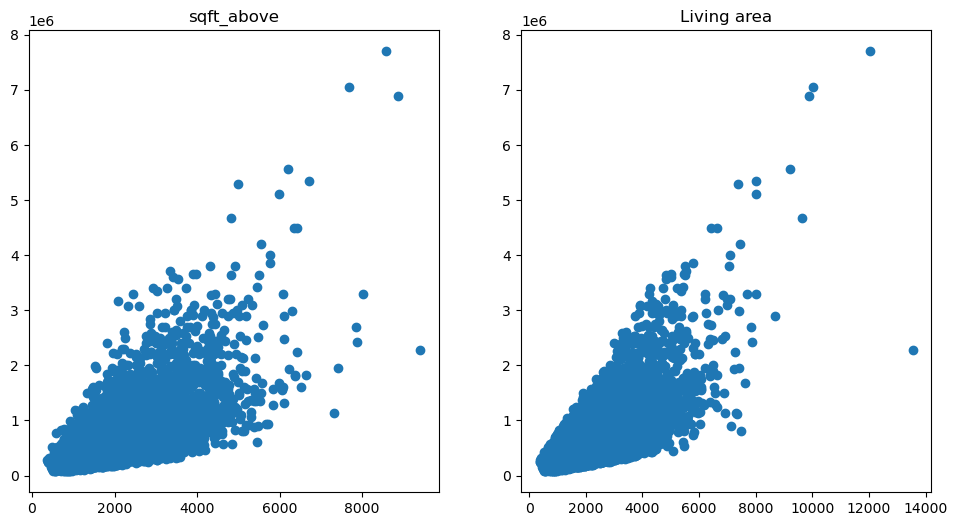

In [22]:
# Plot them individualy against Price
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter(object_1_df['sqft_above'],object_1_df['price'])
plt.title('sqft_above')

plt.subplot(132)
plt.scatter(object_1_df['sqft_living'],object_1_df['price'])
plt.title('Living area')

# plt.tight_layout()
plt.show()

The 2 seem very similar with `sqft_living` with just a bit less variance of the two
First we will form a linear regression model of the 2 housing features individually.

#### Living Area (`sqft_living`):

We form a linear regression model of the 2 parameters.

In [24]:
# Define y and baseline X
y = object_1_df['price']
X_baseline = object_1_df[['sqft_living']]

# use statsmodels
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
# fit model
baseline_results = baseline_model.fit()
# display results
print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 1.882e+04
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:18:08   Log-Likelihood:            -2.6539e+05
No. Observations:               19087   AIC:                         5.308e+05
Df Residuals:                   19085   BIC:                         5.308e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.121e+04   4728.667    -10.830      

### Interpratation

* Our model seems to be statistically significant due to the fact that our F-statistic probability is less than our alpha    value(0.05). 
* The model explains **49.6%** of the variance in `price`.
* Both our y-intercept and slope(coeffecient) are statistically significant(the p-values are less than alpha)
* Our intercept is **-51,210** meaning that a home with 0 square feet it would cost USD-51,210
* Our coefficient is **284.51**. This means that for an additional square foot we expect the price to go up by **USD284.51**


#### Area above ground `sqft_above`

In [25]:
# Define y and baseline X
y2 = object_1_df['price']
X_baseline2 = object_1_df[['sqft_above']]

# use statsmodels
baseline_model2 = sm.OLS(y, sm.add_constant(X_baseline2))
# fit model
baseline_results2 = baseline_model2.fit()
# display results
print(baseline_results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                 1.125e+04
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:18:14   Log-Likelihood:            -2.6752e+05
No. Observations:               19087   AIC:                         5.350e+05
Df Residuals:                   19085   BIC:                         5.351e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.296e+04   5082.783     10.420      0.0

### Interpratation

* Our model seems to be statistically significant due to the fact that our F-statistic probability is less than our alpha    value(0.05). 
* The model explains **37.1%** of the variance in `price`.
* Both our y-intercept and slope(coeffecient) are statistically significant(the p-values are less than alpha).
* Our intercept is **52960** meaning that a home with 0 square feet it would cost **USD52960**.
* Our coefficient is **272.64** This means that for an additional square foot we expect the price to go up by **USD272.64**.

Now we run a multiple linear regression model using both features

In [26]:
# Define X
X = object_1_df[['sqft_above','sqft_living']]

subset_model = sm.OLS(y, sm.add_constant(X))
# fit model
subset_results = subset_model.fit()
# results
print(subset_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     9424.
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:18:40   Log-Likelihood:            -2.6539e+05
No. Observations:               19087   AIC:                         5.308e+05
Df Residuals:                   19084   BIC:                         5.308e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.859e+04   4776.750    -10.171      

### Interpratation

* Our model seems to be statistically significant overall due to the fact that our F-statistic probability is less than our alpha value(0.05). 
* The model explains **49.7%** of the variance in `price`. This shows out model isn't that much of an improvement in term of variance of the data when compared to our earlier model with just `sqft_living`.
* Our y-intercept and all our slopes(coeffecients) are statistically significant(the p-values are less than alpha).
* Our intercept is **-48,590** meaning that a home with 0 square feet for living and above ground it would cost USD-48,590
* Our coefficient for `sqft_above` is **-18.31**. This means that for an additional square foot we expect the price to go up by **-18.31**
* Our coeffiecient for `sqft_living` is **299**. This means that for an additional square foot we expect the price to go up by **USD299**

We then proceed to plot the partial regression for the above features: `sqft_living` and `sqft_above`.

eval_env: 1


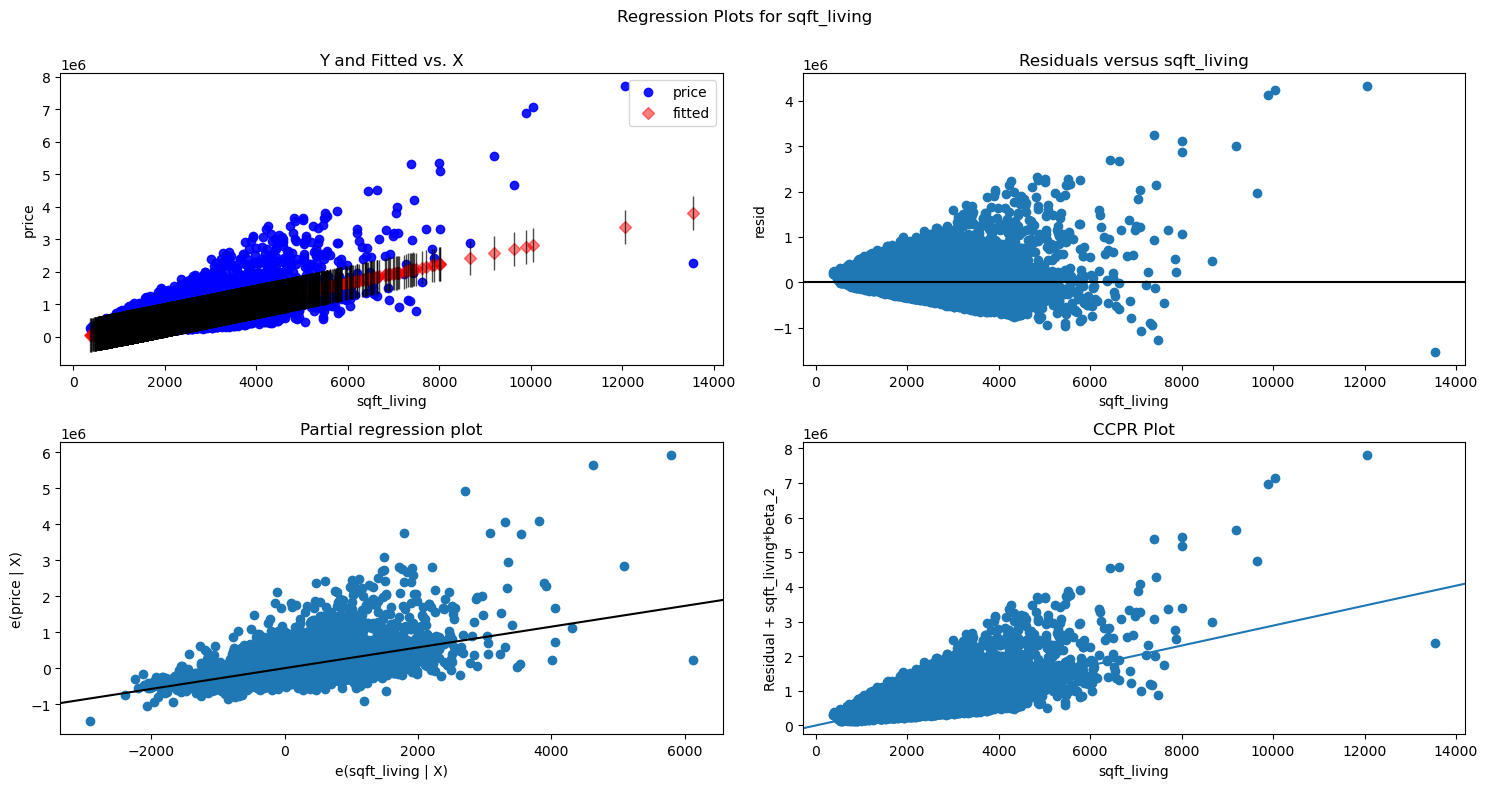

In [37]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_regress_exog(subset_results, "sqft_living", fig=fig)
plt.show()

eval_env: 1


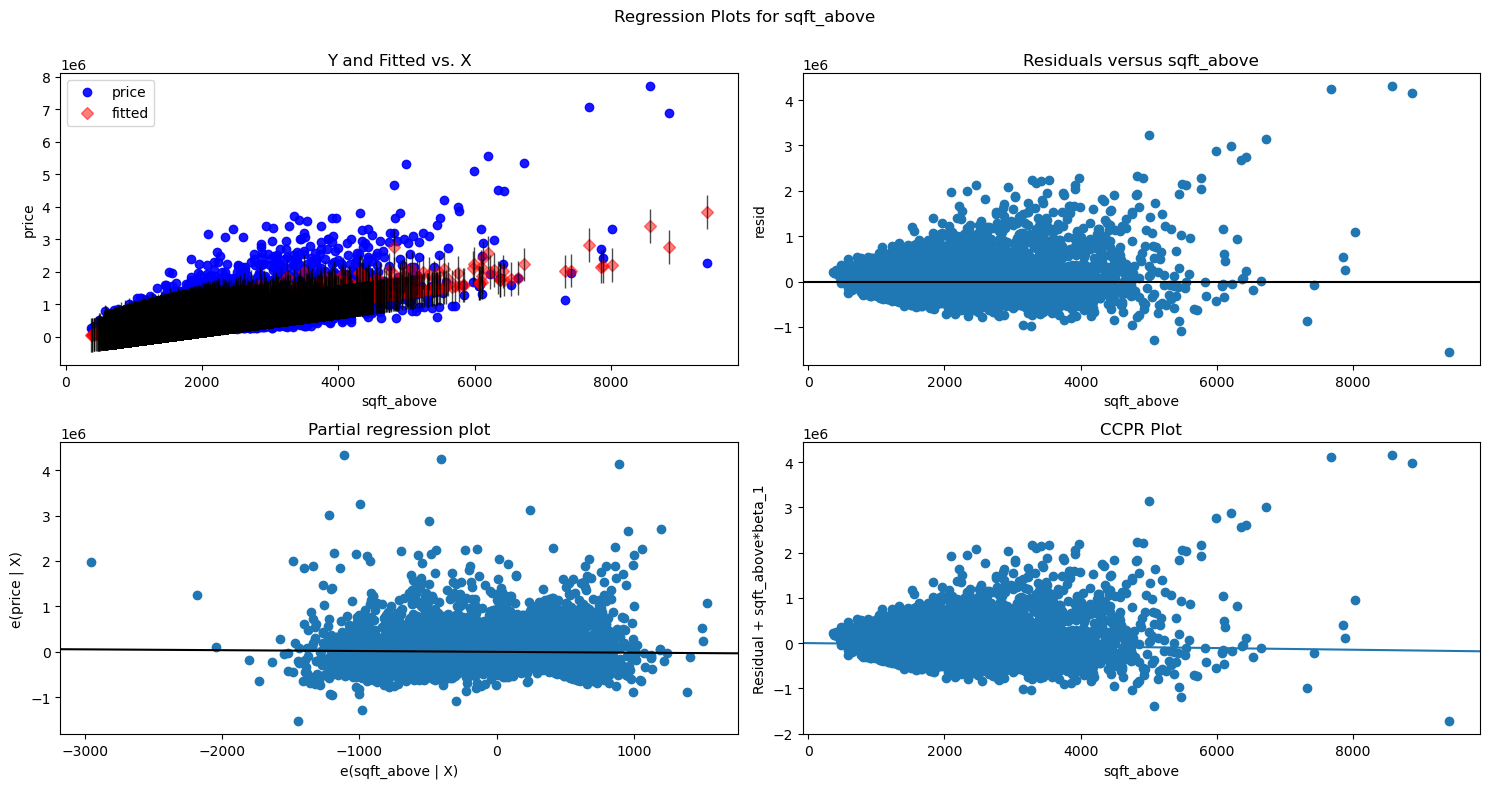

In [27]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_regress_exog(subset_results, "sqft_above", fig=fig)
plt.show()

## INTERPRATE DATA

## CONCLUSION FOR OBJECTIVE ONE

### Objective 2

We want to see the relationship between grade of a house and its facilities/amenities.